In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import normflows as nf
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from fab import FABModel, HamiltonianMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import SimpleBuffer
from torch.autograd import grad
from fab.utils.plotting import plot_contours, plot_marginal_pair
from experiments.make_flow import make_wrapped_normflow_realnvp
import importlib 
import models.ddpm
import models.mlp
import pdb
from tqdm import tqdm
from models.ddpm import GaussianDiffusion, TMLP
from models.mlp import MyMLP, SpectralNormMLP

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

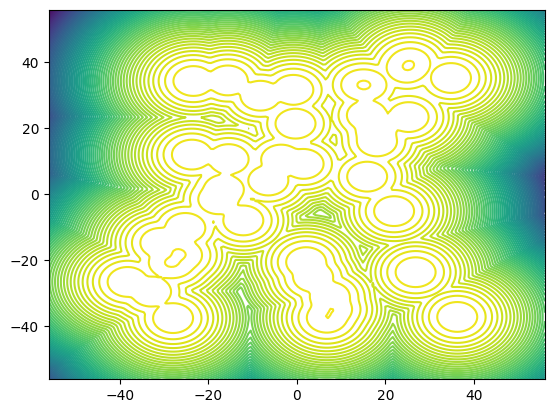

In [4]:
dim = 2
n_mixes = 40
loc_scaling = 40.0  # scale of the problem (changes how far apart the modes of each Guassian component will be)
log_var_scaling = 1.0 # variance of each Gaussian
seed = 0

torch.manual_seed(0)  # seed of 0 for GMM problem
target = GMM(dim=dim, n_mixes=n_mixes,
              loc_scaling=loc_scaling, log_var_scaling=log_var_scaling,
              use_gpu=True, true_expectation_estimation_n_samples=int(1e5))
# plot target
target.to("cpu")
fig, ax = plt.subplots()
plotting_bounds = (-loc_scaling * 1.4, loc_scaling * 1.4)
plot_contours(target.log_prob, bounds=plotting_bounds, n_contour_levels=80, ax=ax, grid_width_n_points=200)
target.to("cuda")

In [5]:
# hyper-parameters

# Flow
n_flow_layers = 15
layer_nodes_per_dim = 40
lr = 1e-4
max_gradient_norm = 100.0
batch_size = 128
n_iterations = 4000
n_eval = 10
eval_batch_size = batch_size * 10
n_plots = 10 # number of plots shows throughout tranining
use_64_bit = True
alpha = 2.0
num_samples = 10000

flow = make_wrapped_normflow_realnvp(dim, n_flow_layers=n_flow_layers, 
                                 layer_nodes_per_dim=layer_nodes_per_dim,
                                act_norm = False)

/mnt/user_storage/active/lib/python3.9/site-packages/torch/_tensor.py:738: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1992.)
  LU, pivots, infos = torch._lu_with_info(


In [6]:
def plot_dataset(samples, gen_samples=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    target.to("cpu")
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[0], n_contour_levels=50, grid_width_n_points=200)

   
    # plot dataset samples
    plot_marginal_pair(samples, ax=axs[0], bounds=plotting_bounds)
    axs[0].set_title("Dataset samples")

    if gen_samples is not None:
        plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[1], n_contour_levels=50, grid_width_n_points=200)
        # plot generated samples
        plot_marginal_pair(gen_samples, ax=axs[1], bounds=plotting_bounds)
        axs[1].set_title("Generated samples")

    else:
        #delete subplot
        fig.delaxes(axs[1])
        
    target.to("cuda")
    plt.show()
    return [fig]

In [7]:
def normalize(x):
    '''
        normalizes to [-1, 1]
    '''
    mins = -50 #torch.min(x, dim=0)[0]
    maxs = 50 #torch.max(x, dim=0)[0]
    ## [ 0, 1 ]
    x = (x - mins) / (maxs - mins + 1e-5)
    ## [ -1, 1 ]
    x = x * 2 - 1
    
    return x, mins, maxs

def unnormalize(x, mins, maxs):
    '''
        x : [ -1, 1 ]
    '''
    # assert x.max() <= 1 and x.min() >= -1, f'x range: ({x.min():.4f}, {x.max():.4f})'
    #x = x * std + mean
    x = (x + 1) / 2
    return x * (maxs - mins) + mins

### Dataset

In [8]:
# normalize the dataset
init_num_samples = 2048
#unnorm_init_samples = target.sample(torch.tensor(init_num_samples).unsqueeze(0)).to(device).detach()
unnorm_init_samples = flow.sample((init_num_samples,)).to(device).detach()
init_energy = target.log_prob(unnorm_init_samples).detach()
init_samples, global_mins_init, global_maxs_init = normalize(unnorm_init_samples)

global_mins_init = -50
global_maxs_init = 50

init_dataset = TensorDataset(init_samples, init_energy)
init_loader = DataLoader(init_dataset, batch_size = 512, shuffle=True) 

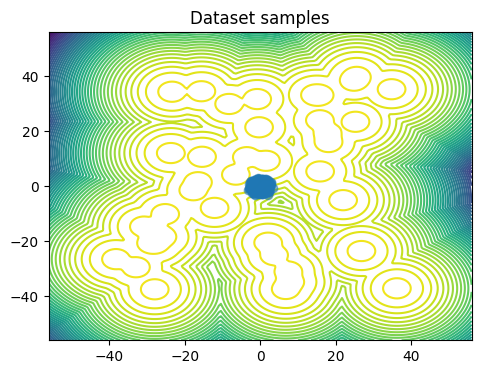

In [9]:
plot_dataset(unnorm_init_samples) # visualise the initial samples
plt.show()

### Networks

In [10]:
beta = 1
vectorfield = MyMLP().to(device)
# reward_model = SpectralNormMLP().to(device)

# diffusion = GaussianDiffusion(
#     model,
#     image_size = 2,
#     timesteps = 1000,          # number of steps
#     auto_normalize= False      # data is already normalized, output will be in range [-1, 1]
# ).to(device)

In [11]:
# opt_diffusion = Adam(diffusion.parameters())
opt_vectorfield = Adam(vectorfield.parameters())

In [12]:
buffer = SimpleBuffer(2, 10000, 1000, initial_sampler=None, 
                      device=device, fill_buffer_during_init=False, sample_with_replacement=True)
buffer.add(init_samples, init_energy)

Buffer not initialised, expected that checkpoint will be loaded.


In [16]:
def reward_matching_loss_dumb(target, vectorfield, constant_noise_scale, global_mins, global_maxs, x, t):     
    t = t.unsqueeze(1)
    noise = constant_noise_scale * t
    # pdb.set_trace()
    x.requires_grad = True
    samples = torch.normal(x, noise ** 0.5)
    samples_energy = target.log_prob(unnormalize(samples, global_mins, global_maxs))
    estimated_scores = torch.autograd.grad(samples_energy.sum(), samples, retain_graph=True)[0]
    pred_scores = vectorfield(samples, t.squeeze())
    
    return (estimated_scores - pred_scores).pow(2).mean()

In [25]:
import torch
import torch as T
import torchsde

class VEReverseSDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'
    
    def __init__(self, score_net):
        super().__init__()
        self.score_model = score_net
    
    def f(self, t, x):
        # pdb.set_trace()
        t = t.repeat(len(x)).to(x.device)
        score = self.score_model(x, 1-t)
        return self.g(t, x).pow(2) * score 
    
    def g(self, t, x):
        return torch.full_like(x, beta ** 0.5)

In [33]:
def generate_samples(ve_reverse_sde):
    num_samples = 400
    target_sigma_squared = 0.0
    # x1 = torch.normal(torch.zeros((num_samples, 2)), torch.full((num_samples, 2), (target_sigma_squared + beta) ** 0.5)).to(device)
    x1 = torch.normal(torch.zeros((num_samples, 2)), torch.full((num_samples, 2), (target_sigma_squared + beta) ** 0.5)).to(device)
    t = torch.linspace(0.0, 1.0, 500)
    with torch.no_grad():
        samples = torchsde.sdeint(ve_reverse_sde, x1, t)
    return samples

### Training Loop

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 | Loss 4337.825195
Epoch 49 | Loss 3649.029541
Epoch 98 | Loss 3787.843018
Epoch 147 | Loss 4089.230957
Epoch 196 | Loss 5056.639648
Epoch 245 | Loss 4365.248047
Epoch 294 | Loss 4118.623047


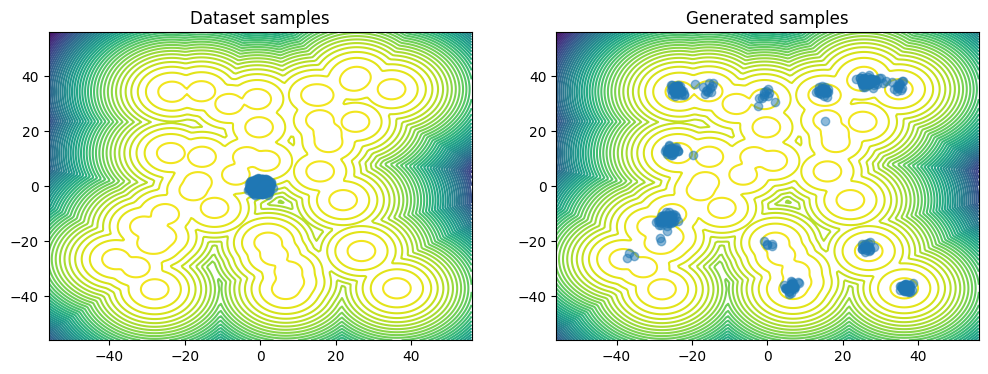

 10%|█         | 1/10 [00:38<05:50, 38.93s/it]

Epoch 0 | Loss 5341.617188
Epoch 49 | Loss 3435.506348
Epoch 98 | Loss 3098.165527
Epoch 147 | Loss 4440.006836
Epoch 196 | Loss 3688.798584
Epoch 245 | Loss 3265.858398
Epoch 294 | Loss 4352.905273


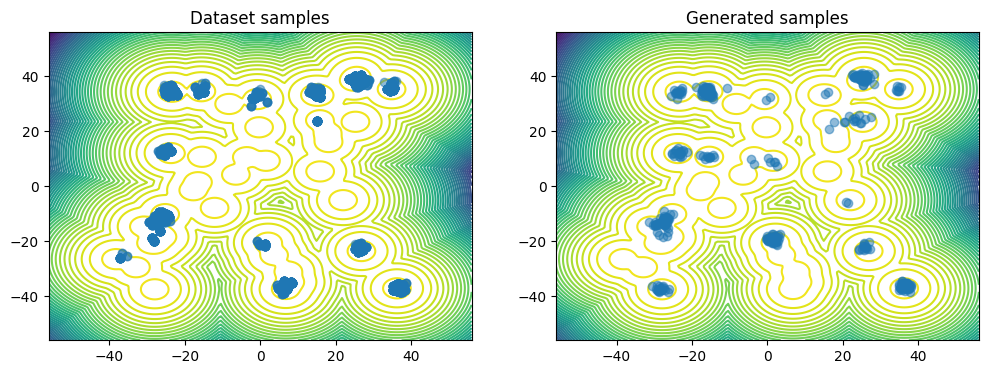

 20%|██        | 2/10 [01:42<07:07, 53.38s/it]

Epoch 0 | Loss 3236.758057
Epoch 49 | Loss 5497.384277
Epoch 98 | Loss 3105.884521
Epoch 147 | Loss 3053.730469
Epoch 196 | Loss 2634.711182
Epoch 245 | Loss 2697.582764
Epoch 294 | Loss 2249.469971


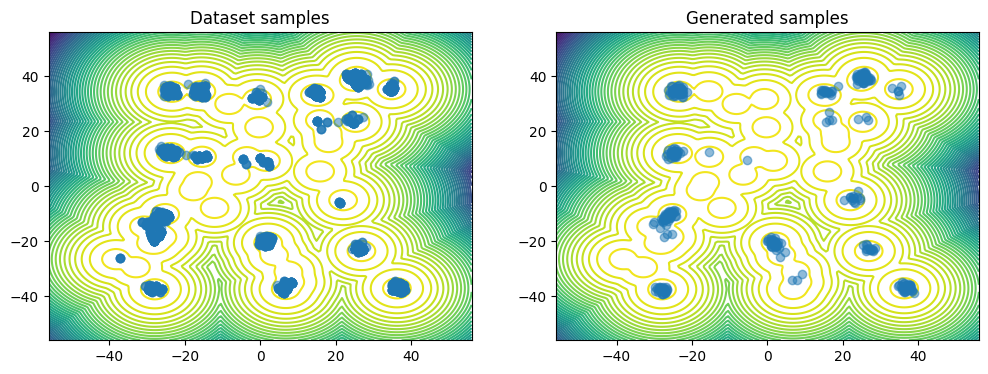

 30%|███       | 3/10 [02:49<06:57, 59.58s/it]

Epoch 0 | Loss 2747.902344
Epoch 49 | Loss 2822.660645
Epoch 98 | Loss 2408.152832
Epoch 147 | Loss 2529.019531
Epoch 196 | Loss 2769.248047
Epoch 245 | Loss 2603.874268
Epoch 294 | Loss 2246.898438


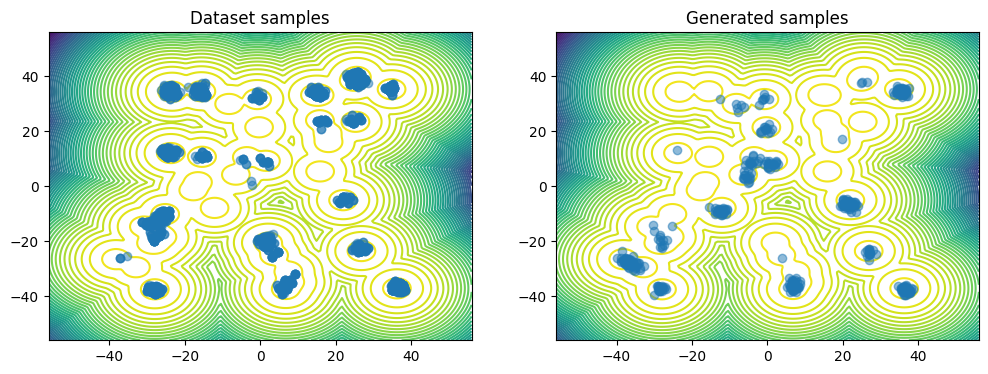

 40%|████      | 4/10 [03:54<06:10, 61.74s/it]

Epoch 0 | Loss 2099.153564
Epoch 49 | Loss 3573.220703
Epoch 98 | Loss 2434.817383
Epoch 147 | Loss 2161.132324
Epoch 196 | Loss 2099.518066
Epoch 245 | Loss 3184.501709
Epoch 294 | Loss 2733.287354


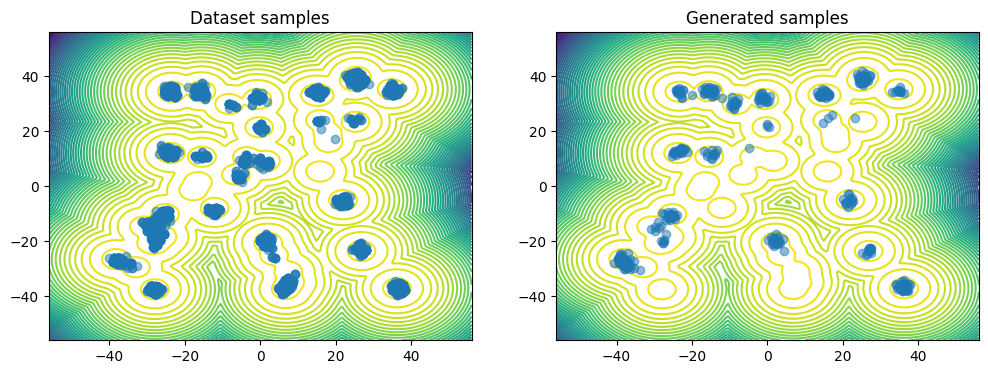

 50%|█████     | 5/10 [04:59<05:14, 62.97s/it]

Epoch 0 | Loss 1965.100708
Epoch 49 | Loss 1574.709839
Epoch 98 | Loss 1893.748291
Epoch 147 | Loss 2781.956299
Epoch 196 | Loss 1944.432495
Epoch 245 | Loss 2671.710205
Epoch 294 | Loss 1735.874390


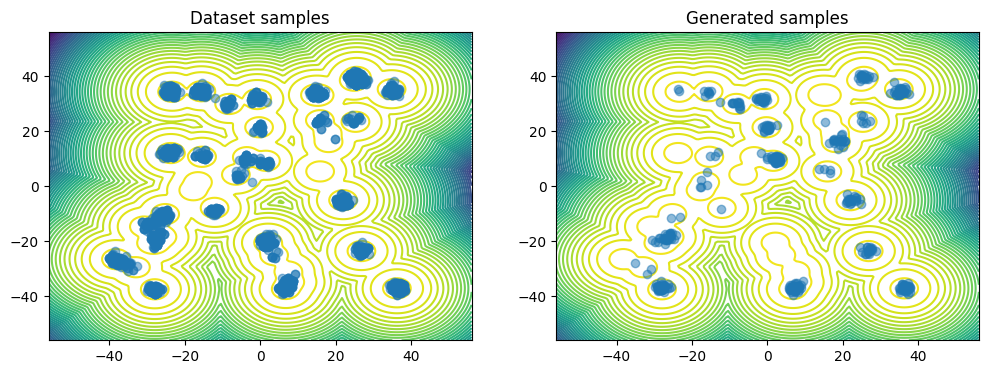

 60%|██████    | 6/10 [06:03<04:12, 63.13s/it]

Epoch 0 | Loss 1598.351440
Epoch 49 | Loss 1475.949341
Epoch 98 | Loss 2625.836426
Epoch 147 | Loss 2219.480957
Epoch 196 | Loss 1489.436157
Epoch 245 | Loss 1830.850830
Epoch 294 | Loss 1640.229004


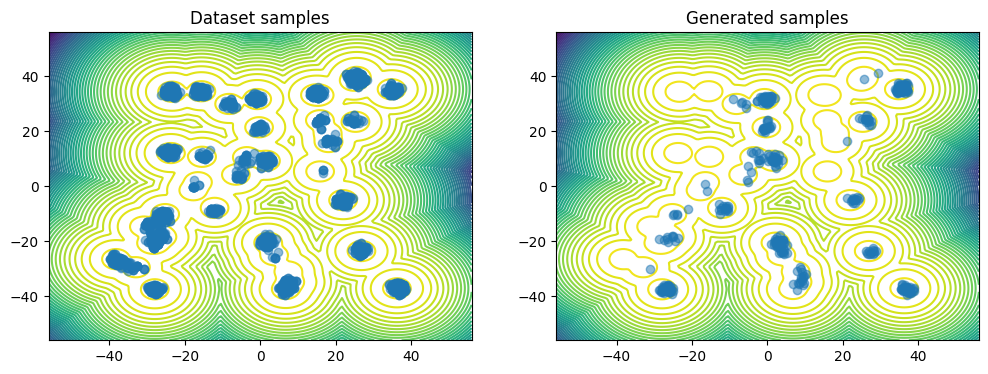

 70%|███████   | 7/10 [07:09<03:13, 64.36s/it]

Epoch 0 | Loss 1724.106079
Epoch 49 | Loss 1257.969116
Epoch 98 | Loss 1914.944092
Epoch 147 | Loss 1573.965332
Epoch 196 | Loss 1018.204590
Epoch 245 | Loss 1855.356445
Epoch 294 | Loss 1421.178589


In [ ]:
outer_epochs= 10
inner_epochs = 300
reward_epochs = 1 #300

num_samples = 2048

train_dataset = TensorDataset(init_samples.clone(), init_energy.clone())
trainloader = DataLoader(train_dataset, batch_size = 512, shuffle=True) 
global_mins, global_maxs = global_mins_init, global_maxs_init
ve_reverse_sde = VEReverseSDE(vectorfield).to(device)

for epoch in tqdm(range(outer_epochs)):
    for epoch in range(inner_epochs):
        total_loss = 0.
        for samples,_ in trainloader:
            samples = samples.to(device)
            opt_vectorfield.zero_grad()
            t = torch.rand(len(samples), device=device)
            loss = reward_matching_loss_dumb(target, vectorfield, 1, global_mins, global_maxs, samples, t)
            total_loss += loss.item()
            loss.backward()
            opt_vectorfield.step()
        if epoch % 49 == 0:
            print("Epoch %d | Loss %f" % (epoch, loss.item()))


    # Resample with guidance
    samples = generate_samples(ve_reverse_sde)[-1]
    samples_energy = target.log_prob(unnormalize(samples, global_mins, global_maxs)).detach()

    # Update Buffer 
    buffer.add(samples, samples_energy)

    plot_dataset(unnormalize(train_dataset.tensors[0], global_mins, global_maxs), 
                 unnormalize(samples, global_mins, global_maxs))
    plt.show()
    # Resample data from the buffer
    samples, samples_energy, _ = buffer.sample(512 * 10)
    train_dataset = TensorDataset(samples, samples_energy)
    trainloader = DataLoader(train_dataset, batch_size = 512, shuffle=True)

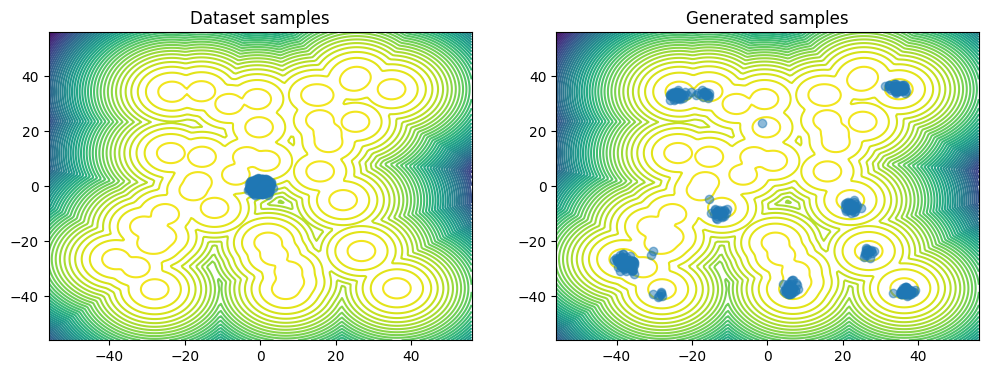

[<Figure size 1200x400 with 2 Axes>]

In [32]:
plot_dataset(unnormalize(train_dataset.tensors[0], global_mins, global_maxs), 
             unnormalize(samples[-1], global_mins, global_maxs))


### Sampling

torch.Size([1000, 400, 2])